In [2]:
import numpy as np
import networkx as nx
from cdlib import algorithms
from sklearn import cluster
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import itertools
mpl.rcParams['figure.figsize'] = (12, 10)

In [3]:
G = nx.Graph()

In [4]:
G.add_nodes_from([1, 2, 3, 4, 5])
G.add_edge(1, 2, weight=0.8)
G.add_edge(2, 3, weight=0.6)
G.add_edge(1, 3, weight=0.5)
G.add_edge(2, 4, weight=0.1)
G.add_edge(2, 5, weight=0.2)
G.add_edge(3, 4, weight=0.1)
G.add_edge(3, 5, weight=0.1)
G.add_edge(4, 5, weight=1)

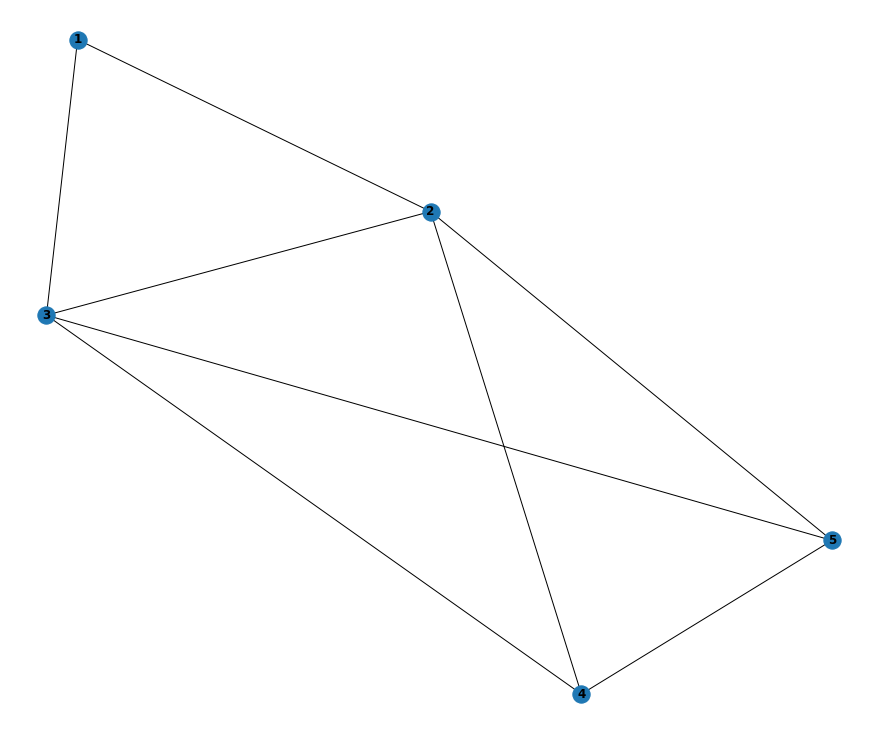

In [5]:
nx.draw(G, with_labels=True, font_weight='bold')

In [6]:
# G = nx.Graph(np.array([[0, 1, 0.1],[1, 0, 0.2], [0.1, 0.2, 0]]))

{(1, 2): Text(0.0006742924027356295, 0.6934049070847976, '0.8'),
 (1, 3): Text(0.3073238156939251, 0.6337915221078765, '0.5'),
 (2, 3): Text(0.1346115526561018, 0.3271964291926742, '0.6'),
 (2, 4): Text(-0.07882131101598851, -0.2977758774637703, '0.1'),
 (2, 5): Text(-0.31452148999548013, -0.1426107375593086, '0.2'),
 (3, 4): Text(0.22782821227520092, -0.35738926244069147, '0.1'),
 (3, 5): Text(-0.00787196670429069, -0.20222412253622973, '0.1'),
 (4, 5): Text(-0.22130483037638102, -0.8271964291926743, '1')}

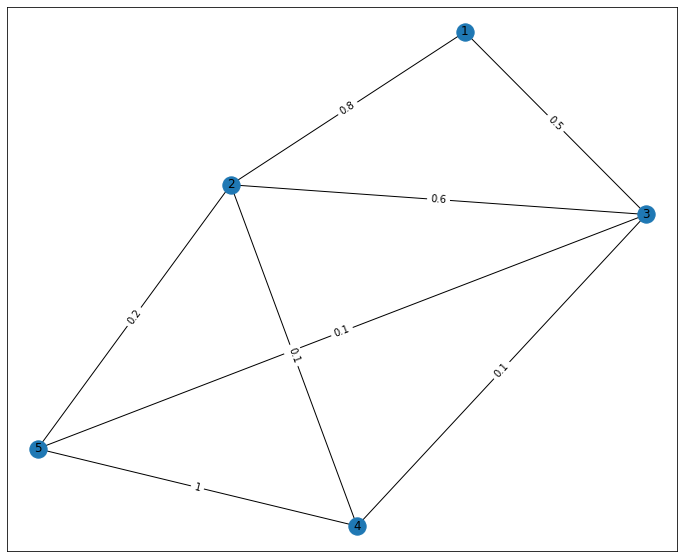

In [7]:
pos=nx.spring_layout(G) # pos = nx.nx_agraph.graphviz_layout(G)
nx.draw_networkx(G,pos)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

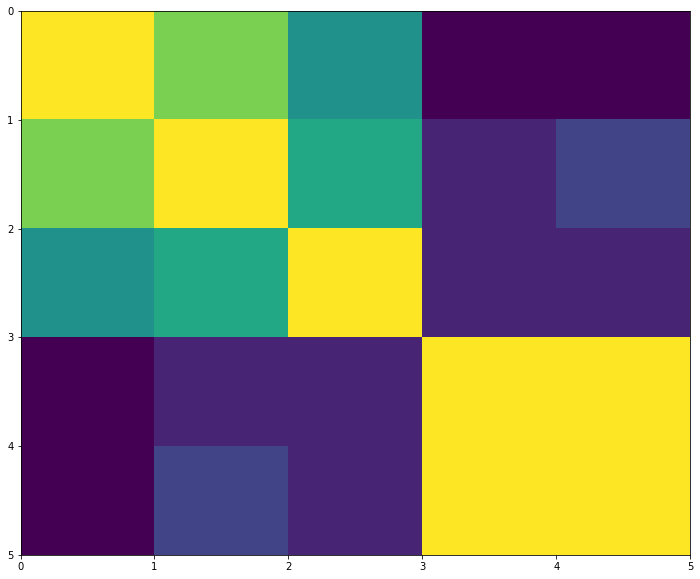

In [8]:
test_adj = nx.adjacency_matrix(G).todense()
plt.pcolormesh(test_adj+np.identity(5))
plt.gca().invert_yaxis()

In [9]:
n_clusters = 2
kmeans = cluster.KMeans(n_clusters=n_clusters).fit(test_adj+np.identity(5))
kmeans.labels_

array([0, 0, 0, 1, 1], dtype=int32)

In [10]:
print(np.triu(test_adj+np.identity(5)))

[[1.  0.8 0.5 0.  0. ]
 [0.  1.  0.6 0.1 0.2]
 [0.  0.  1.  0.1 0.1]
 [0.  0.  0.  1.  1. ]
 [0.  0.  0.  0.  1. ]]


In [11]:
coms = algorithms.louvain(G)
print(coms.communities)

[[1, 2, 3], [4, 5]]


In [12]:
for k in nx.algorithms.connected_components(G):
    print(k)

{1, 2, 3, 4, 5}


In [13]:
from scipy import io

In [14]:
dictin = io.loadmat('../Data/threeClustersOut.mat')
all_labels = dictin['out_details'][0, 25][0, 0][2][3, :, :]

FileNotFoundError: [Errno 2] No such file or directory: '../Data/threeClustersOut.mat'

In [15]:
def adj_from_labels(all_labels):
    size = all_labels.shape[1]
    adjacency = np.zeros((size, size))
    for i in range(size):
        for j in range(i+1, size):
            weight = np.sum(all_labels[:, i]==all_labels[:, j])/size
            adjacency[i, j] = weight
            adjacency[j, i] = weight
    return adjacency

In [16]:
adj_graph = nx.Graph(adjacency)

NameError: name 'adjacency' is not defined

In [17]:
plt.pcolormesh(adjacency)
plt.gca().invert_yaxis()

NameError: name 'adjacency' is not defined

In [18]:
coms = algorithms.louvain(adj_graph)

NameError: name 'adj_graph' is not defined

In [19]:
reindex = []
for com in coms.communities:
    reindex += com

In [20]:
reordered = np.ones((100, 100))
for i in range(100):
    for j in range(i+1, 100):
        m = reindex[i]
        n = reindex[j]
        reordered[i, j] = adjacency[m, n]
        reordered[j, i] = adjacency[m, n]
plt.pcolormesh(reordered)
plt.gca().invert_yaxis()

NameError: name 'adjacency' is not defined

In [21]:
def matrix_kmeans(adjacency, n_clusters=2):
    similarities = adjacency+np.identity(adjacency.shape[0])
    kmeans = cluster.KMeans(n_clusters=n_clusters).fit(similarities)
    labels = kmeans.labels_
    communities = [list(np.argwhere(labels==j).ravel()) for j in np.unique(labels)]
    return communities

In [22]:
def reorder_matrix(adjacency, communities):
    size = adjacency.shape[0]
    similarities = adjacency+np.identity(adjacency.shape[0])
    reindex = []
    for com in communities:
        reindex += com
    reordered = np.ones((size, size))
    for i in range(size):
        for j in range(i+1, size):
            m = reindex[i]
            n = reindex[j]
            reordered[i, j] = similarities[m, n]
            reordered[j, i] = similarities[m, n]
    return reordered

In [23]:
def blockdiag(communities):
    comlens = [len(com) for com in communities]
    out = np.zeros((np.sum(comlens), np.sum(comlens)))
    start = 0
    for length in comlens:
        out[start:start+length, start:start+length] = 1
        start += length
    return out

In [24]:
plt.pcolormesh(blockdiag(communities))
plt.gca().invert_yaxis()

NameError: name 'communities' is not defined

In [25]:
plt.pcolormesh(np.abs(blockdiag(communities)-reordered))
plt.gca().invert_yaxis()

NameError: name 'communities' is not defined

In [26]:
def all_errors(adjacency, communities, norm=1):
    reordered = reorder_matrix(adjacency, communities)
    ideal = blockdiag(communities)
    return (np.abs(ideal-reordered)**norm)**(1/norm)

In [27]:
plt.hist((errors.ravel(), errors2.ravel()), bins=20)
print(np.sum(errors.ravel()))

NameError: name 'errors' is not defined

NameError: name 'errors' is not defined

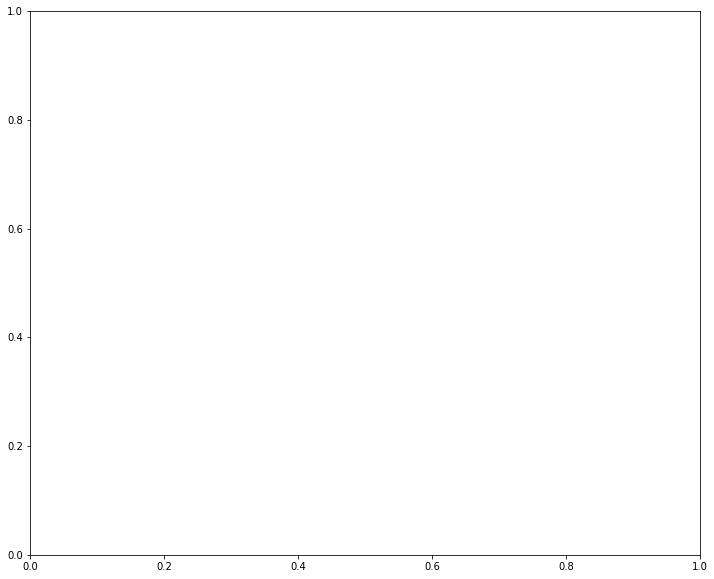

In [28]:
fig, ax = plt.subplots()
sns.kdeplot(errors.ravel(), ax=ax, clip=(0, 1))
sns.kdeplot(errors2.ravel(), ax=ax, clip=(0, 1))
print(np.sum(errors.ravel()**2))
print(np.sum(errors2.ravel()**2))

NameError: name 'dictin' is not defined

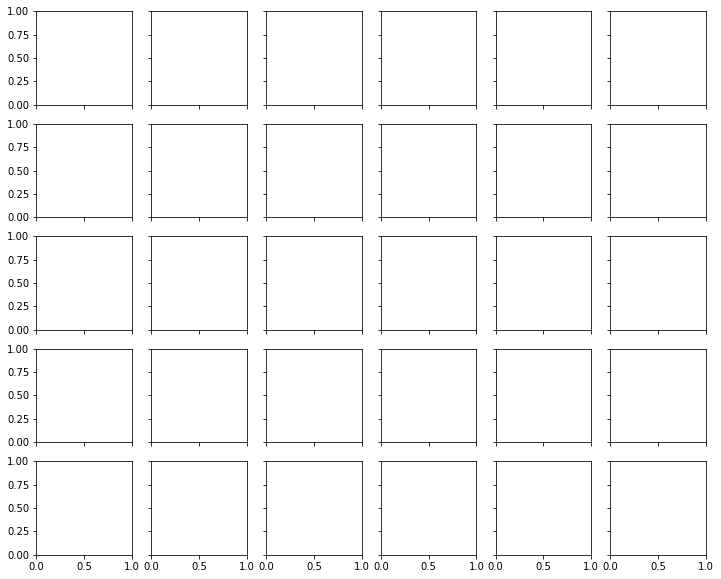

In [29]:
fig, ax = plt.subplots(5, 6, sharex=True, sharey=True)
cost_values = np.zeros((6, 5, 4))
for k, (i, j) in enumerate(itertools.product(range(6), range(5))):
    for clusters in range(4):
        all_labels = dictin['out_details'][0, k][0, 0][2][clusters, :, :]
        adjacency = adj_from_labels(all_labels)
        communities = matrix_kmeans(adjacency, n_clusters=clusters+2)
        errors = all_errors(adjacency, communities, norm=2)
        sns.kdeplot(errors.ravel(), ax=ax[j, i], clip=(0, 1), cumulative=True, color=sns.color_palette()[clusters])
        cost_values[i, j, clusters] = np.sum(errors)/adjacency.shape[0]**2

In [ ]:
print(cost_values)
print(np.argmin(cost_values, axis=2).T+2)
# for i, j in itertools.product(range(6), range(5)):
#     n_clusters = np.argmin(cost_values[i, j, :])+2
fig, ax = plt.subplots(5, 6, sharex=True, sharey=True)
for i, j in itertools.product(range(6), range(5)):
    ax[j, i].plot([2, 3, 4, 5], cost_values[i, j, :]/90000)
ax[0, 4].set_xticks([2, 3, 4, 5])

In [ ]:
test_matrix = np.triu(np.random.uniform(size=(500, 500)))
test_matrix = test_matrix+test_matrix.T
for k in range(500):
    test_matrix[k, k] = 1
plt.pcolormesh(test_matrix)
plt.gca().invert_yaxis()

In [ ]:
errorlist = np.zeros((5,))
fig, ax = plt.subplots(3, 5, sharex=True, sharey=True)
for n in range(5):
    communities = matrix_kmeans(test_matrix, n_clusters=n+2)
    reordered = reorder_matrix(test_matrix, communities)
    ideal = blockdiag(communities)
    errors = all_errors(test_matrix, communities)
    errorlist[n] = np.sum(errors)
    ax[0, n].pcolormesh(reordered)
    ax[1, n].pcolormesh(ideal)
    ax[2, n].pcolormesh(errors)
ax[0, 0].invert_yaxis()

In [ ]:
print(np.sum((1-test_matrix).ravel())/250000)
print(errorlist/250000)

In [ ]:
cd = algorithms.louvain(nx.Graph(test_matrix))
reordered = reorder_matrix(test_matrix, cd.communities)
ideal = blockdiag(communities)
errors = all_errors(test_matrix, communities)
fig, ax = plt.subplots(3, 1, sharex=True, sharey=True)
ax[0].pcolormesh(reordered)
ax[1].pcolormesh(ideal)
ax[2].pcolormesh(errors)
ax[0].invert_yaxis()
print(np.sum(errors)/250000)

In [30]:
all_labels = dictin['out_details'][0, 20][0, 0][2][0, :, :]
adjacency = adj_from_labels(all_labels)
print(all_labels)

NameError: name 'dictin' is not defined

In [31]:
def adj_from_labels(all_labels):
    num_samples = all_labels.shape[1]
    num_trials = all_labels.shape[0]
    adjacency = np.ones((num_samples, num_samples))
    for i in range(num_samples):
        for j in range(i+1, num_samples):
            weight = np.sum(all_labels[:, i]==all_labels[:, j])/num_trials
            adjacency[i, j] = weight
            adjacency[j, i] = weight
    return adjacency

In [32]:
all_labels.shape

NameError: name 'all_labels' is not defined

In [33]:
communities = matrix_kmeans(adjacency)
plt.pcolormesh(adjacency)
plt.gca().invert_yaxis()
plt.figure()
plt.pcolormesh(reorder_matrix(adjacency, communities))
plt.gca().invert_yaxis()
plt.figure()
errormat = all_errors(adjacency, communities)
plt.pcolormesh(errormat)
plt.gca().invert_yaxis()

NameError: name 'adjacency' is not defined

In [34]:
np.sum(errormat)/90000

NameError: name 'errormat' is not defined

In [35]:
def modularity(adjacency, communities):
    k = np.sum(adjacency, axis=-1)
    m = np.sum(k)/2
    Q = 0
    for com in communities:
        for c in com:
            for d in com:
                B = adjacency[c, d]-k[c]*k[d]/(2*m)
                Q += B/(2*m)
    return Q